In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def crop_minAreaRect_with_margin(img, rect, margin=0):
    # Source: https://stackoverflow.com/questions/37177811/

    # Rotate img
    angle = rect[2]
    rows, cols = img.shape[0], img.shape[1]
    matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img_rot = cv2.warpAffine(img, matrix, (cols, rows))

    # Rotate bounding box
    rect0 = (rect[0], rect[1], 0.0)
    box = cv2.boxPoints(rect)
    pts = np.intp(cv2.transform(np.array([box]), matrix))[0]
    pts[pts < 0] = 0

    # Add margin to the bounding box coordinates
    pts[:, 0] = np.clip(pts[:, 0], margin, cols - 1 - margin)
    pts[:, 1] = np.clip(pts[:, 1], margin, rows - 1 - margin)

    # Crop and return
    return img_rot[
        pts[1][1] - margin : pts[0][1] + margin, pts[1][0] - margin : pts[2][0] + margin
    ]

dtype: uint8, shape: (122, 120, 3), min: 0, max: 255


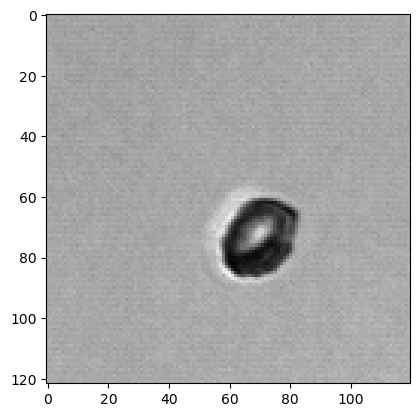

In [29]:
path = "/home/t.afanasyeva/deep_learning_anaemias/resources/images_subset/Experiment_Group_A2_393.tif"
# img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
img = cv2.imread(path)
assert img is not None, "file could not be read, check with os.path.exists()"

print(f"dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}")
plt.imshow(img, cmap="grey")

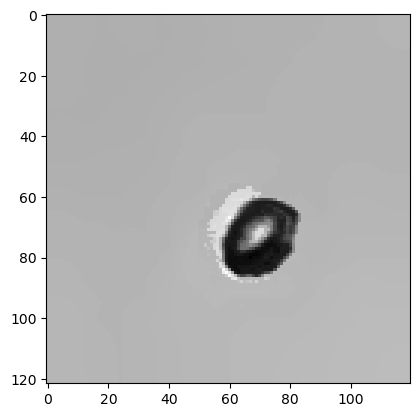

In [30]:
filt = cv2.pyrMeanShiftFiltering(img, sp=10, sr=30, maxLevel=2)
gray_filt = cv2.cvtColor(filt, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_filt, cmap="grey")

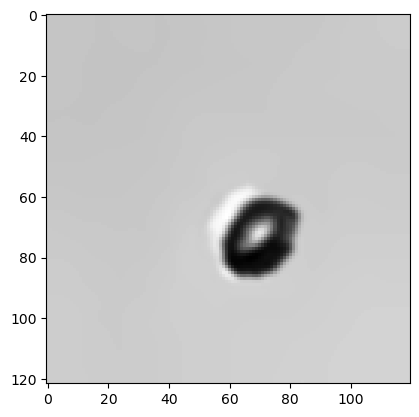

In [31]:
# Smooth image
blur = cv2.GaussianBlur(gray_filt, (5, 5), 0)
plt.imshow(blur, cmap="grey")

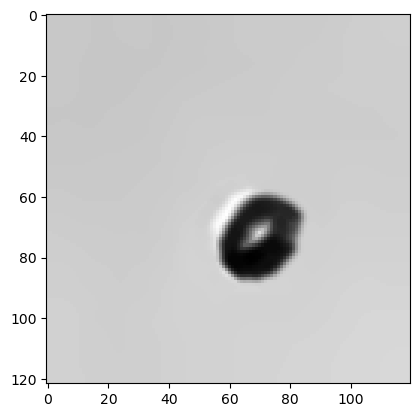

In [87]:
radius = 1  # Define the radius of the circlar kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * radius + 1, 2 * radius + 1))

erod = cv2.erode(blur, kernel, iterations=1)

plt.imshow(erod, cmap="grey")

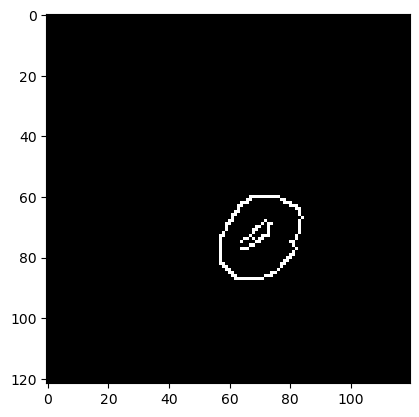

In [88]:
edges = cv2.Canny(erod, threshold1=150, threshold2=200)
plt.imshow(edges, cmap="gray")

In [89]:
# contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

# # temp = cv.drawContours(img, contours, -1, (0,255,0), 3)
# cnt = contours[0]

# temp = cv.drawContours(img, [cnt], 0, (0, 255, 0), 3)
# plt.imshow(temp, cmap="gray")

In [90]:
# _, threshold = cv2.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
# closing = cv.morphologyEx(gray, cv.MORPH_CLOSE, kernel)

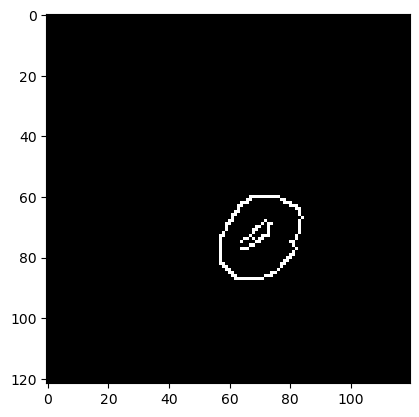

In [91]:
# Remove cells at the border
from skimage.segmentation import clear_border

no_bord = clear_border(edges)
plt.imshow(no_bord, cmap="grey")

In [92]:
# contours, hierarchy = cv2.findContours(no_bord, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# cnt = contours[0]
# # cv2.drawContours(img, [cnt], 0, (0,255,0), 1)
# # plt.imshow(img, cmap="gray")

In [93]:
contours, hierarchy = cv2.findContours(no_bord, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

valid_contours = []

for i, (contour, h) in enumerate(zip(contours, hierarchy[0])):
    # Check if the contour is not inside another contour (parent index is -1)
    if h[3] == -1:
        area = cv2.contourArea(contour)
        # Check if the area is less than 1200 pixels
        if (area <= 1200) and (area >= 200):
            valid_contours.append(contour)

    if valid_contours:
        # Randomly select one of the valid contours
        cnt = random.choice(valid_contours)

    #     img_copy = img.copy()
    #     cv2.drawContours(img_copy, [cnt], -1, (0, 255, 0), 3)

    #     plt.imshow(img_copy, cmap="gray")
    # else:
    #     print("No valid contours found.")

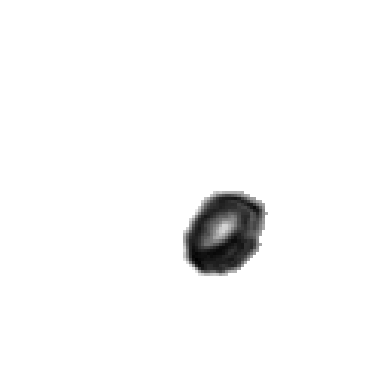

In [94]:
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Create a mask of the same size as the grayscale image, initialized to black
mask = np.zeros_like(grey)

# Draw the contour on the mask in white
cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

# Invert the mask so that the area outside the contour is white
mask_inv = cv2.bitwise_not(mask)

white_background = img.copy()

# Set the outside area to white using the inverted mask
white_background[mask_inv == 255] = 255

# Display the result
plt.imshow(cv2.cvtColor(white_background, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

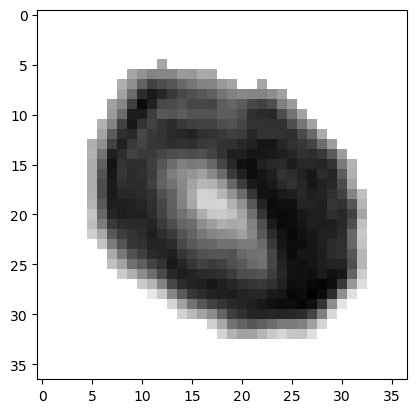

In [95]:
rect = cv2.minAreaRect(cnt)
croped = crop_minAreaRect_with_margin(white_background, rect, margin=5)
plt.imshow(croped, cmap="gray")

In [96]:
# def image_resize(src, height=None, inter=cv2.INTER_AREA):
#     dimension = None
#     (h, w) = src.shape[:2]

#     if height is None:
#         height = h

#     r = height / float(h)  # Resizing ratio
#     dimension = (int(w * r), height)

#     resized = cv2.resize(src, dimension, interpolation=inter)

#     return resized

In [97]:
# # Resize the image
# resized = image_resize(croped, height=None)

# plt.imshow(resized, cmap="grey")

(100, 100)


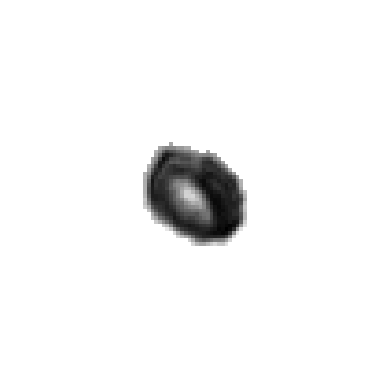

In [98]:
def image_pad(
    src,
    target_size=(100, 100),
    bordertype=cv2.BORDER_REPLICATE,
):

    # Calculate padding to make the image square
    pad_width = abs(src.shape[1] - src.shape[0])
    left = pad_width // 2
    right = pad_width - left
    top = 0
    bottom = 0

    # Pad the image to make it square
    padded = cv2.copyMakeBorder(src, top, bottom, left, right, bordertype)
    print(target_size)

    # Add additional padding to make the resulting image 100x100
    additional_padding = max(0, target_size[0] - padded.shape[0])
    top_padding = additional_padding // 2
    bottom_padding = additional_padding - top_padding
    additional_padding = max(0, target_size[1] - padded.shape[1])
    left_padding = additional_padding // 2
    right_padding = additional_padding - left_padding

    final_padded = cv2.copyMakeBorder(
        padded, top_padding, bottom_padding, left_padding, right_padding, bordertype
    )

    return final_padded


padded_image = image_pad(croped)
plt.imshow(padded_image, cmap="gray")
plt.axis("off")
plt.show()

In [99]:
import hashlib


def get_hash_with_randomness(file_path):
    # Generate a random salt
    salt = os.urandom(16)  # 16 bytes of randomness

    # Read the file and compute the hash
    with open(file_path, "rb") as f:
        file_bytes = f.read()  # read entire file as bytes
        bytes_with_salt = file_bytes + salt  # append the salt to the file content
        readable_hash = hashlib.sha256(bytes_with_salt).hexdigest()

    return readable_hash

In [100]:
hash_for_filename = get_hash_with_randomness(path)
print(hash_for_filename)  # This will be your file name

77a16312f0c3374142bd0738a5fa28eec66210690bea3f41758efe1b27fa09fe


In [101]:
my_dict = {}
my_dict.setdefault(readable_hash, [])
my_dict[readable_hash].append(path)

NameError: name 'readable_hash' is not defined

In [ ]:
my_dict[readable_hash][0]

'/home/t.afanasyeva/deep_learning_anaemias/resources/images_subset/discocyte.tif'